## b345 - 16/02/2008 - CLPX-2 -MARSS

Here we are comparing MARSS (Microwave Airborne Radiometer Scanning System) emissivity measurements from the FAAM aircraft with some radar data taking from a satellite. The data were provided by Chawn Harlow. The original MARSS data are in csv format. Although it is possible to write your own plugin in many cases it might be easier to convert the data into a netCDF, which CIS natively supports.

In [1]:
%matplotlib inline

import datetime
import os

ROOT_DATA_PATH = '/Users/watson-parris/Desktop/cis_workshop/data/b345'

# date of flight
year, month, day = 2008, 2, 16

### Converting the MARSS data from csv to netCDF

The MARSS data come as a text file in csv format. We use pandas to read in the data into a DataFrame first.

In [2]:
import pandas as pd

# Date parser, which will give use a datetime object for every data line in the MARSS data
# the first column in the csv file is seconds past midnight
dateparser = lambda x: datetime.datetime(year, month, day)+datetime.timedelta(seconds=int(float(x)))

# column definition for the txt file
colnames=['time', 'lat', 'lon', 'emis89', 'emis157', 'emis183']
ifile = os.path.join(ROOT_DATA_PATH, 'marss_emiss_b345.txt')
df = pd.read_csv(ifile, names=colnames, skiprows=1, parse_dates=[0,], date_parser=dateparser)
df.set_index('time', inplace=True)

Now the data are all in a pandas.DataFrame. In a next step we create a new CIS dataset from scratch.

In [3]:
import cis
from cis.data_io.ungridded_data import UngriddedData, UngriddedDataList, Metadata
from cis.data_io.Coord import Coord
from cis.time_util import convert_datetime_to_std_time, cis_standard_time_unit

OVERWRITE_NETCDF = True

lon = Coord(df.lon.values, Metadata('longitude', units='degree_east'), 'x')
lat = Coord(df.lat.values, Metadata('latitude', units='degree_north'), 'y')
time = Coord(convert_datetime_to_std_time(df.index.to_pydatetime()),
             Metadata('time', units=cis_standard_time_unit))

emis89 = UngriddedData(df.emis89.values, 
                       Metadata('emis89', long_name='Emissivity at 89Ghz', units=1), 
                       [lat, lon, time])
emis157 = UngriddedData(df.emis157.values, 
                        Metadata('emis157', long_name='Emissivity at 157Ghz', units=1), 
                        [lat, lon, time])
emis183 = UngriddedData(df.emis183.values, 
                        Metadata('emis183', long_name='Emissivity at 183Ghz', units=1), 
                        [lat, lon, time])

b345 = UngriddedDataList([emis89, emis157, emis183])

Now that we have CIS objects we can easily save to NetCDF using the `.save_data()` method. This is almost exactly the code we would need for a plugin if we were reading lots of these files.

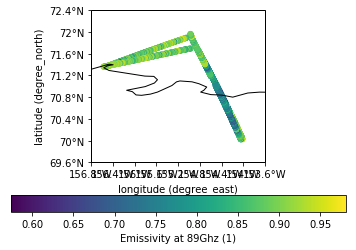

In [4]:
# Map plot
b345[0].plot(how='scatter2d')

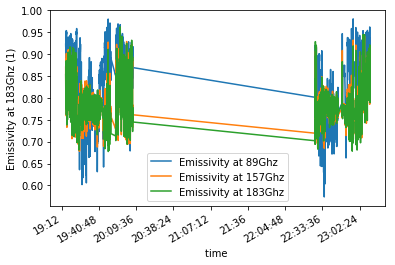

In [5]:
# Time series plot
b345.plot(xaxis='time')

### Converting the Satellite data

Next are the satellite data. Once more we convert the data into a CIS suitable format. The original data are in geotiff, which is converted in a two step process into a NetCDF using tools provided by gdal. 

The first step is to to warp the data into the EPSG:4326 coordinate reference system, which will provide longitude and latitude as dimensions (coordinates):

In [6]:
# !gdalwarp -t_srs EPSG:4326 R164129269G3Q001_aoi_sigma_dB.tif R164129269G3Q001_aoi_sigma_dB.4326.tif

In a second step we convert the dataset to netCDF:

In [7]:
 # !gdal_translate -of netCDF R164129269G3Q001_aoi_sigma_dB.4326.tif R164129269G3Q001_aoi_sigma_dB.4326.nc

Let's have a quick look what is in the file:

In [8]:
# !ncdump -h R164129269G3Q001_aoi_sigma_dB.4326.nc

Rename the variable "Band1" to "aoi":

In [9]:
# !ncrename -v Band1,aoi R164129269G3Q001_aoi_sigma_dB.4326.nc

### Analysis

Read in the converted radar data.

In [10]:
aoi_ifile = os.path.join(ROOT_DATA_PATH, 'R164129269G3Q001_aoi_sigma_dB.4326.nc')
aoi = cis.read_data(aoi_ifile, 'aoi')

Plot the satellite data as a heatmap, which is the default type for a gridded dataset.

/Users/watson-parris/anaconda/envs/cis_env3/lib/python3.5/site-packages/iris/coords.py:802: UserWarning: Coordinate 'longitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))
/Users/watson-parris/anaconda/envs/cis_env3/lib/python3.5/site-packages/iris/coords.py:802: UserWarning: Coordinate 'latitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))


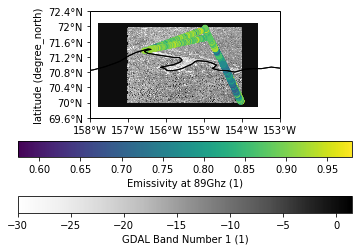

In [11]:
ax = aoi.plot(cmap='Greys')
# plot the MARSS data on top
b345[0].plot(ax=ax)

In [12]:
# Will linearly interpolate the radar data onto the aircraft track in all dimensions
aoi_col, = aoi.collocated_onto(b345[0])

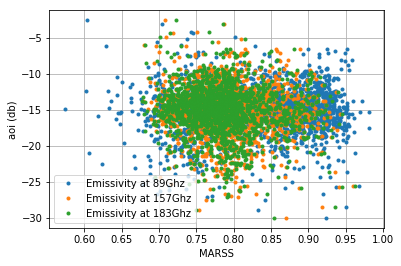

In [13]:
import matplotlib.pyplot as plt
plt.figure()
ax = plt.subplot()
for emis in b345:
    ax.plot(emis.data, aoi_col.data, '.', label=emis.name())

ax.legend()
ax.set_xlabel('MARSS')
ax.set_ylabel('aoi (db)')
ax.grid(True)